In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
sns.set(font_scale=2, style='ticks')
from activity_swim_bout import *
from utils import cont_mode
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from utils import *

In [2]:
vol_file = Path('depreciated/analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

## Single neuron analysis

In [3]:
row = dat_xls_file.iloc[0]
folder = row['folder']
fish = row['fish']
print(f'Processing {folder} {fish}')
dat_dir = dir_folder/f'{folder}/{fish}/Data/'
swim_dir = dir_folder/f'{folder}/{fish}/swim/'
dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
num_cell = spk.shape[0]
spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

subvolt = dff.copy()
for n, ndff in enumerate(dff):
    subvolt[n, :] = medfilt(ndff, kernel_size=51)

Processing 03152018 Fish1-1


In [4]:
_ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

In [5]:
sub_list = np.zeros((r_swim.shape[0], subvolt.shape[0]))
remove_list = np.zeros(r_swim.shape[0]).astype('bool')
for n, n_swim in enumerate(swim_starts):
    try:
        sub_list[n, :] = subvolt[:, n_swim+50:n_swim+250].mean(axis=-1)
    except:
        remove_list[n]=True
task_period_ = task_period.copy()
task_period_[remove_list] = 0

In [6]:
sub_list_ = np.array(sub_list)
lda = LDA()
lda.fit(sub_list_[task_period_<3, :], task_period_[task_period_<3])
# sub_pc = svd.transform(subvolt.T)
# plt.plot(sub_list_.mean(axis=-1), task_period_, '.')

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [7]:
lda.score(sub_list_[task_period_<3, :], task_period_[task_period_<3])

0.588957055214724

## See if the high gain and low gain can be decoded using LDA coder

In [17]:
spk_list = np.zeros((r_swim.shape[0], spk.shape[0]))
remove_list = np.zeros(r_swim.shape[0]).astype('bool')
for n, n_swim in enumerate(swim_starts):
    try:
        spk_list[n, :] = spk[:, n_swim+0:n_swim+250].mean(axis=-1)*300
    except:
        remove_list[n]=True
task_period_ = task_period.copy()
task_period_[remove_list] = 0
spk_list_ = np.array(spk_list)
lda = LDA()
lda.fit(spk_list_[task_period_<3, :], task_period_[task_period_<3])
print(lda.score(spk_list_[task_period_<3, :], task_period_[task_period_<3]))
coef_ = lda.coef_

0.8404907975460123


In [32]:
spk_list_pre = np.zeros((r_swim.shape[0], spk.shape[0]))
remove_list_pre = np.zeros(r_swim.shape[0]).astype('bool')
for n, n_swim in enumerate(swim_starts):
    try:
        spk_list_pre[n, :] = spk[:, n_swim-250:n_swim].mean(axis=-1)*300
    except:
        remove_list_pre[n]=True
    if np.isnan(spk_list_pre[n, :]).sum()>0:
        remove_list_pre[n]=True
task_period_ = task_period.copy()
task_period_[remove_list_pre] = np.inf
print(lda.score(spk_list_pre[task_period_<3, :], task_period_[task_period_<3]))
coef_ = lda.coef_

0.8110599078341014


In [33]:
pred_ = spk_list_pre.dot(coef_.T)

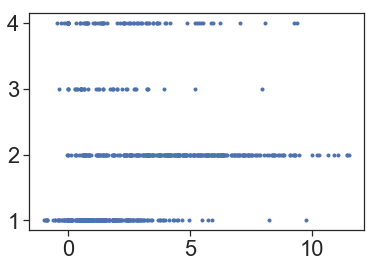

In [35]:
plt.plot(pred_, task_period_, '.')

In [36]:
from scipy.signal import find_peaks
num_burst = np.zeros(r_swim.shape[0])
int_burst = np.zeros(r_swim.shape[0])
max_burst = np.zeros(r_swim.shape[0])
ave_burst = np.zeros(r_swim.shape[0])
fir_burst = np.zeros(r_swim.shape[0])

for n_burst in range(r_swim.shape[0]):
    rswim = r_swim[n_burst, 50:200]
    lswim = l_swim[n_burst, 50:200]
    swim_ = np.sqrt(rswim**2+lswim**2)
    peaks_ = find_peaks(swim_, prominence=0.5)[0] 
    if len(peaks_) >1:
        num_burst[n_burst] = len(peaks_)/2
        int_burst[n_burst] = np.nanmean(np.diff(peaks_))
        max_burst[n_burst] = swim_.max()
        ave_burst[n_burst] = swim_[peaks_].mean()
        fir_burst[n_burst] = peaks_[0]
    
burst_list = [num_burst, int_burst, max_burst, ave_burst, fir_burst]
burst_list = np.asarray(burst_list)

In [45]:
n_task = task_period.max().astype('int')
swim_task_index_ = (swim_task_index-1)%n_task+1
swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
swim_bout_index_task[0] = 1
for n_bout in range(len(swim_task_index_)-1):
    if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
        swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
    else:
        swim_bout_index_task[n_bout] = 1

In [54]:
k_ = boxcarKernel(600)
spk_smooth = spk.copy()
for ncell in range(spk_smooth.shape[0]):
    spk_smooth[ncell] = smooth(spk[ncell], k_)*300
pop_act = spk_smooth.T.dot(coef_.T)
pop_act = pop_act.ravel()

[-0.48336326315345896, 0.11138981647538271]


Text(0.5,0,'Neural dynamics in late delay')

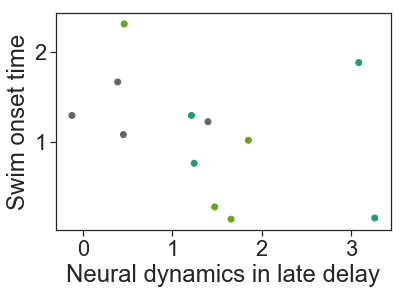

In [93]:
from scipy.stats import spearmanr
test_on_ = np.where((frame_stimParams[2][:-1]==3) & (frame_stimParams[2][1:]==4))[0]
first_swim_on = swim_starts[swim_ind] - test_on_
win_ = [-600, 0]
pred_swim_on = np.zeros(len(test_on_))
for n, n_on in enumerate(test_on_):
    pred_swim_on[n] = pop_act[n_on+win_[0]:n_on+win_[1]].mean()
plt.scatter(pred_swim_on, first_swim_on/300, c=np.arange(12)%3, cmap=plt.cm.Dark2)
corr_, p = spearmanr(pred_swim_on, first_swim_on)
print([corr_, p])
plt.ylabel('Swim onset time')
plt.xlabel('Neural dynamics in late delay')

In [52]:
swim_starts[swim_ind] - np.where((frame_stimParams[2][:-1]==3) & (frame_stimParams[2][1:]==4))[0]

array([ 45, 694, 388, 388,  41, 324, 565, 305, 367, 228,  82, 500])

In [72]:
lda_ = LDA(n_components=4)
lda_.fit((burst_list.T)[task_period<3], task_period[task_period<3])
burst_pca = burst_list.T.dot(lda_.coef_.T)
burst_pca = burst_pca - np.mean(burst_pca)

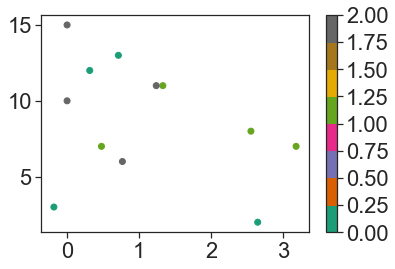

In [92]:
swim_on_ind = (swim_bout_index_task== 1) & (task_period_==4)
# plt.scatter(pred_[swim_on_ind].ravel(), burst_pca[swim_on_ind], c=np.arange(12)%3, cmap=plt.cm.nipy_spectral)
plt.scatter(pred_[swim_on_ind].ravel(), burst_list[4][swim_on_ind], c=np.arange(12)%3, cmap=plt.cm.Dark2)
plt.colorbar()
plt.show()

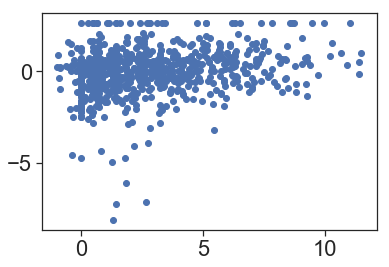

In [99]:
swim_on_ind = (swim_bout_index_task== 1) & (task_period_==4)
# plt.scatter(pred_[swim_on_ind].ravel(), burst_pca[swim_on_ind], c=np.arange(12)%3, cmap=plt.cm.nipy_spectral)
# plt.scatter(pred_[swim_on_ind].ravel(), burst_list[4][swim_on_ind], c=np.arange(12)%3, cmap=plt.cm.Dark2)
# plt.scatter(pred_.ravel(), burst_list[4])
plt.scatter(pred_.ravel(), burst_pca)
# plt.colorbar()
plt.show()

### Correlate neural dynamics with behavioral mode

In [116]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(spk_list_[~remove_list_pre], burst_pca[~remove_list_pre])
reg.score(spk_list_pre[~remove_list_pre], burst_pca[~remove_list_pre])

0.05249463094129569

In [117]:
reg.coef_

array([[-0.02780899,  0.07991873, -0.09299996,  0.05267349,  0.06070998,
         0.01081671,  0.00945477, -0.01841522,  0.26937827, -0.00979928,
         0.12906354,  0.13601119,  0.02969273,  0.08961047, -0.32756063,
        -0.03664474, -0.09821763, -0.06932792, -0.02755687, -0.11803576,
         0.12802938,  0.20073112,  0.01793622,  0.11403324, -0.09963019]])

## check if the fish has a memory

In [94]:
burst_list[3][swim_on_ind].reshape(-1, 3).shape

(4, 3)

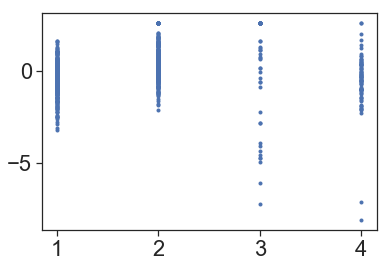

In [111]:
plt.plot(task_period_, burst_pca, '.')